# **Twitter Sentiment Analysis:** 
### *Understanding Public Sentiment on Apple and Google Products via Twitter*

## **Business Understanding**
### **Background**
In today’s highly competitive technology industry, public opinion plays a major role in shaping brand reputation, customer loyalty, and product adoption. Tech giants such as Apple, Google, and Android consistently dominate online conversations, with Twitter (X) serving as a powerful platform where users openly share their experiences, frustrations, and excitement.

Companies in the smartphone and software ecosystem rely heavily on social media platforms to understand how customers feel about their products, monitoring sentiment is crucial for:

- **Brand reputation management** – Understanding how consumers perceive Apple, Google, and Android products in real time.

- **Market intelligence** – Identifying user pain points, emerging trends, and competitive advantages.

- **Customer engagement** – Responding proactively to feedback to improve user experience.

- **Strategic decision-making** – Informing product development, marketing strategies, and customer support initiatives.

However, manually analyzing thousands of Tweets is time-consuming, inconsistent, and inefficient. There is a clear need for an automated system that can classify sentiment (positive, negative, or neutral) from user-generated content.

### **Problem Statement**
Despite the dominance of Apple, Google, and Android in the technology sector, their success is heavily influenced by consumer perception and online conversations. However, due to the vast and unstructured nature of Twitter data, it is difficult to systematically understand whether public opinion is positive, negative, or neutral. This creates a challenge for businesses and stakeholders who need actionable insights to improve brand reputation, customer engagement, and strategic decision-making.

### **Project Objectives**
This project seeks to analyze Twitter conversations about Apple, Google, and Android products using natural language processing (NLP) techniques. By classifying tweets into positive, negative, and neutral sentiments, the analysis will uncover the prevailing consumer opinions and brand perceptions.

Ultimately, the insights generated can support businesses, marketers, and stakeholders in the tech industry to track consumer sentiment, benchmark against competitors, and drive data-informed decisions.

### **StakeHolders**
- **Apple & Google Marketing Teams** – to measure customer reactions to new product launches and campaigns.

- **Product Development Teams** – to identify areas where users express dissatisfaction, helping guide improvements.

- **Customer Service Teams** – to proactively address common customer complaints raised on social media.

- **Business Analysts & Executives** – to monitor overall brand reputation and benchmark against competitors.

### **Value of the Project**

1. Enables real-time monitoring of brand sentiment on Twitter.

2. Provides actionable insights for marketing, customer service, and product strategy.

3. Reduces reliance on manual Tweet analysis, saving time and resources.

4. Helps companies track sentiment trends over time and respond faster to customer concerns.

### **In Scope**
- As a proof of concept, we will first attempt a binary classification (positive vs. negative).

- After that, we will extend to a multiclass classification (positive, negative, neutral).

*Out of scope: topics beyond Apple, Google, and Android, and advanced sentiment like sarcasm or irony detection.*

## **Data Understanding**
This section contains the data's initial exploration. It provides information about the source of the data, helps have a peek at the dataset to understand it's structure such as its shape, data types, etc. and also understand what kind of mess the data has, such as missing values, duplicated records, outliers, among other data integrity issues.

### **Data Source**
The dataset comes from CrowdFlower via [data.world](https://data.world/crowdflower/brands-and-product-emotions/workspace/file?filename=judge-1377884607_tweet_product_company.csv). It contains Tweets about Apple and Google products that have been human-labeled for sentiment.

#### *Why is this dataset important to the project?*
This dataset is highly suitable for our project because the text of Tweets directly reflects customer opinions. Analyzing these Tweets allows stakeholders (product managers, marketing teams) to understand public sentiment efficiently without manually reading thousands of messages.

### **Mini Exploration**
This section involves exploring the data to understand its structure as well as it's contents better. It will include;
- Importing relevant libraries and loading the dataset

- Checking it's shape, data types etc.

- Checking for data integrity issues

#### *Importing relevant packages*

In [1]:
# Import relevant packages.
import re
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Load dataset
text_df = pd.read_csv('../../assets/Data/Raw_Data/judge-1377884607_tweet_product_company.csv', encoding="ISO-8859-1")

# Preview the first 5 rows
text_df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


#### *Data Summary: shapes, data types*
This section checks the dataset's shape and data types, this is important as it will help in identifying if the data is sufficient for modeling or not. We'll also know what kind of data we will be working with.

- We are using the `.shape()` method to check the dataset's shape.

In [3]:
# Shape of the dataset
print("Rows, Columns:", text_df.shape)

Rows, Columns: (9093, 3)


The dataset contains 9093 rows and 3 columns, giving us enough records to work with.

- We are using the `.info()` method to retrieve a concise summary of the data.

In [4]:
# Data types and non-null values
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


The dataset contains 3 columns and all contain values stored as objects. 

Also, 2 out of the 3 columns contain null values, that is the `tweet_text` and the `emotion_in_tweet_is_directed_at` columns.

#### *Checking Data Integrity Issues*
In this section we are looking to identify whether the data contains:
- Missing values

- Duplicated records

In [5]:
# Find total number and percentage of missing values.
# Retrieve sum of missing values.
missing = text_df.isnull().sum()

# Turn into percentage.
missing_percent = (missing / len(text_df)) * 100

# Store in a DataFrame.
missing_df = pd.DataFrame({'Missing Values': missing, 'Percent': missing_percent})

# Filter out columns that don't have missing values.
missing_df[missing_df['Missing Values'] > 0]

,Missing Values,Percent
tweet_text,1,0.010997
emotion_in_tweet_is_directed_at,5802,63.807324


As observed earlier, the data contains missing values in 2 columns. 1 missing value in the `tweet_text` column and in more than 60% records in the `emotion_in_tweet_is_directed_at` column.

- In the next cell we are checking for duplicates using the `.duplicated()` method.

In [6]:
# Check for duplicates
duplicate_records = text_df.duplicated().sum()

print(f'The dataset contains {duplicate_records} duplicate records')

The dataset contains 22 duplicate records


The data contains 22 duplicated records.

#### *Descriptive Analysis*
We are using the `.describe()` method to generate a summary description of the data.

In [7]:
# Summary stats for numerical columns
text_df.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


- `tweet_text` contains 9093 records and 9065 unique values. This is a clear indication that we have duplicated rows in the dataset.

- `emotion_in_tweet_is_directed_at` contains 3219 records, has 9 unique values where ipad is the most frequent product with 946 reviews.

- `is_there_an_emotion_directed_at_a_brand_or_product` contains 9093 records and has 4 unique values where *No emotion toward brand or product* is the most frequent record with 5389 reveiws.

### **Data Understanding Summary**
#### *Structure*
The dataset contains structured data stored in 9,093 rows and 3 columns, with records in all the columns stored as objects.

#### *Data Issues and the Next Steps*
| Found                 |    Action                                                          |
| --------------------- | ------------------------------------------------------------------ |
| Missing values        | Replace or drop                                                    |
| Duplicates            | Drop using `.drop_duplicates()`                                    |
| Long column names     | Replace with short, easy names                                     |
| Categorical issues    | Fix inconsistent labels (If any)                                   |

## **Data Cleaning**
In this section we are cleaning the dataset to prepare it for modeling. In the previous section, we performed the initial data exploration which not only helped in understanding the dataset but also pointing out some of the issues that could otherwise mislead the project's findings.

This is a crucial step for any project before training a machine learning model because it ensures the data is accurate, consistent, and relevant, leading to better model performance and more reliable predictions. Cleaning data helps remove errors, inconsistencies, and irrelevant information that can negatively impact the model's ability to learn and generalize.

This session will involve:
- Dealing with missing values

- Dealing with duplicate records

- Dealing with categorical issues

- Change column names

- Identifying relevant columns based on domain knowledge

- Cleaning the reviews and tokenizing them

### **Rename Columns**

In [8]:
# Rename columns
text_df.rename(columns={'tweet_text': 'tweet', 'emotion_in_tweet_is_directed_at': 'product', 'is_there_an_emotion_directed_at_a_brand_or_product': 'emotion'}, inplace=True)

# Preview changes
text_df.columns

Index(['tweet', 'product', 'emotion'], dtype='object')

### **Missing Values**
During the data understanding, we found that 2 columns contain missing values, in this section, we are exploring the columns further to make sure there is no underlying reason other than the fact that the columns are incomplete.

This step is crucial as missing values in datasets can significantly impact the accuracy and reliability of analyses and machine learning models. Addressing ensures valid results and avoids introducing bias.

The columns with missing values include: `tweet`, `product`. 

In [9]:
# Preview the `product` column
text_df['product'].unique()

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', nan, 'Android',
       'Apple', 'Android App', 'Other Google product or service',
       'Other Apple product or service'], dtype=object)

In [10]:
# Get unique product names from the product column (ignoring missing values)
product_list = text_df['product'].dropna().unique().tolist()

In [11]:
# Extracting product names from tweet column
def extract_product(tweet, product_list):
    for product in product_list:
        # Case-insensitive search
        if re.search(r'\b' + re.escape(product) + r'\b', tweet, flags=re.IGNORECASE):
            return product
    return None

# Apply function only where product is missing
text_df['product_filled'] = text_df.apply(lambda row: row['product'] if pd.notnull(row['product']) else extract_product(str(row['tweet']), product_list) if pd.notnull(row['tweet']) else None, axis=1)

In [12]:
# Compare before vs after filling
print("Missing before:", text_df['product'].isna().sum())
print("Missing after :", text_df['product_filled'].isna().sum())


Missing before: 5802
Missing after : 796


- Extracting product names from the tweet column has brought down the number of missing product records from 5000+ to 700+ missing records. 

- In the next cells we are comparing the two columns to ensure we do not accidentally “lose” some values.

In [13]:
# Compare the two columns
products = text_df[['product', 'product_filled']]
products

,product,product_filled
0,iPhone,iPhone
1,iPad or iPhone App,iPad or iPhone App
2,iPad,iPad
3,iPad or iPhone App,iPad or iPhone App
4,Google,Google
...,...,...
9088,iPad,iPad
9089,NaN,Google
9090,NaN,Google
9091,NaN,iPhone


In [14]:
# Find rows where product_filled is missing but product is not
check_df = text_df[text_df['product_filled'].isna() & text_df['product'].notna()]

print("Number of such cases:", check_df.shape[0])
check_df[['tweet', 'product', 'product_filled']].head(10)

Number of such cases: 0


,tweet,product,product_filled


In [15]:
# Drop rows with missing tweet text
text_df.dropna(subset=['tweet'], inplace=True)

# Drop column with a lot of missing values
text_df.drop(columns= ['product'], inplace= True)

# Verify that the row has been dropped
print("Missing values after dropping rows with missing tweet text:")
display(text_df.isnull().sum())

Missing values after dropping rows with missing tweet text:


tweet               0
emotion             0
product_filled    795
dtype: int64

In [16]:
# Preview changes
text_df.head()

,tweet,emotion,product_filled
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,iPhone
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,iPad or iPhone App
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion,iPad
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion,iPad or iPhone App
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,Google


### **Standardization**
In this section we are standardizing all the categorical columns by turning them all to lower case, correcting alternate spellings and fixing typos (if any). This is crucial because otherwise we would treat them as separate categories.

We are reviewing columns content before standarzing them.

In [17]:
# View the most occuring records in categorical columns
for col in text_df.select_dtypes(include='object').columns:
    print(f"\n--- {col.upper()} ---")
    print(text_df[col].value_counts(dropna=False).head(15))  # show top 15 values


--- TWEET ---
RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw                                5
RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw                                             4
RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #SXSW                                4
RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #SXSW                                             3
#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan    2
RT @mention RT @mention It's not a rumor: Apple is opening up a temporary store in downtown Austin for #SXSW and the iPad 2 launch {link}     2
Win free iPad 2 from webdoc.com #sxsw RT                                                                                 

In [18]:
# Create standardization function.
def clean_categorical_columns(df, show_value_counts=False, top_n=10):
    """
    Standardizes text in all object columns:
    - Converts to lowercase
    - Strips whitespace
    - Replaces multiple spaces with one

    Parameters:
    - df: your dataframe
    - show_value_counts: if True, prints value counts per column
    - top_n: how many top values to show if show_value_counts is True

    Returns:
    - cleaned dataframe
    """
    df_cleaned = df.copy()
    cat_cols = df_cleaned.select_dtypes(include='object').columns

    for col in cat_cols:
        df_cleaned[col] = (
            df_cleaned[col]
            .astype(str)
            .str.lower()
            .str.strip()
            .str.replace(r'\s+', ' ', regex=True)
        )
        if show_value_counts:
            print(f"\n--- {col.upper()} ---")
            print(df_cleaned[col].value_counts(dropna=False).head(top_n))
    
    return df_cleaned

text_cleaned = clean_categorical_columns(text_df, show_value_counts=True)


--- TWEET ---
rt @mention google to launch major new social network called circles, possibly today {link} #sxsw                                            9
rt @mention marissa mayer: google will connect the digital &amp; physical worlds through mobile - {link} #sxsw                               9
win free ipad 2 from webdoc.com #sxsw rt                                                                                                     6
google to launch major new social network called circles, possibly today {link} #sxsw                                                        4
rt @mention it's not a rumor: apple is opening up a temporary store in downtown austin for #sxsw and the ipad 2 launch {link}                3
rt @mention rt @mention google to launch major new social network called circles, possibly today {link} #sxsw                                3
rt @mention rt @mention it's not a rumor: apple is opening up a temporary store in downtown austin for #sxsw and the ipad 2 lau

In [19]:
# Define a mapping dictionary
emotion_map = {
    "positive emotion": "positive",
    "negative emotion": "negative",
    "i can't tell": "mixed",
    "no emotion toward brand or product": "neutral"
}

# Apply mapping
text_cleaned['emotion'] = text_cleaned['emotion'].replace(emotion_map)

# Check unique values after renaming
print(text_cleaned['emotion'].unique())


['negative' 'positive' 'neutral' 'mixed']


### **Dropping Duplicate Records**
During data understanding we found that the dataset contains 22 duplicated records, also, when checking the columns' unique values, we noticed that some columns contained same texts in different cases. Here we are dropping them to maintain data integrity and accuracy, prevent biased analysis, optimize storage and performance, and ensure that machine learning models can generalize well. 

Duplicates can distort findings, and negatively impact the quality of insights derived from the data. We are using the `.drop_duplicates()` method.

In [20]:
# Drop duplicate records
text_df.drop_duplicates(inplace= True)

In [21]:
# Confirm duplicates are dropped
duplicate_records = text_df.duplicated().sum()

print(f'The dataset contains {duplicate_records} duplicate records')

The dataset contains 0 duplicate records


### **Preprocessing `tweet` Column**
Here we are creating a function that takes in the `tweet` column in our dataframe and preprocesses the documents. The preprocessed text will be saved to a new column in our `text_cleaned` dataframe.

The function:
- removes punctuation

- removes stopwords

- tokenizes the texts

- removes links and @ mentions

In [22]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')


stop_words = set(stopwords.words('english'))

def clean_tweet_text(text):
    # Ensure the input is a string
    if not isinstance(text, str):
        return "" # Return an empty string for non-string inputs

    # Remove mentions (@...) and links (http://...)
    text = re.sub(r'@\w+|http\S+', '', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply the cleaning function to the tweet_text column
text_cleaned['cleaned_tweets'] = text_cleaned['tweet'].apply(clean_tweet_text)

# Display the original and cleaned text for comparison
display(text_cleaned[['tweet', 'cleaned_tweets']].head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,tweet,cleaned_tweets
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,3g iphone 3 hrs tweeting rise_austin dead need...
1,@jessedee know about @fludapp ? awesome ipad/i...,know awesome ipadiphone app youll likely appre...
2,@swonderlin can not wait for #ipad 2 also. the...,wait ipad 2 also sale sxsw
3,@sxsw i hope this year's festival isn't as cra...,hope years festival isnt crashy years iphone a...
4,@sxtxstate great stuff on fri #sxsw: marissa m...,great stuff fri sxsw marissa mayer google tim ...


In [23]:
# Preview the cleaned data's summary
text_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet           9092 non-null   object
 1   emotion         9092 non-null   object
 2   product_filled  9092 non-null   object
 3   cleaned_tweets  9092 non-null   object
dtypes: object(4)
memory usage: 355.2+ KB


In [24]:
# preview the first 5 rows
text_cleaned.head()

,tweet,emotion,product_filled,cleaned_tweets
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,negative,iphone,3g iphone 3 hrs tweeting rise_austin dead need...
1,@jessedee know about @fludapp ? awesome ipad/i...,positive,ipad or iphone app,know awesome ipadiphone app youll likely appre...
2,@swonderlin can not wait for #ipad 2 also. the...,positive,ipad,wait ipad 2 also sale sxsw
3,@sxsw i hope this year's festival isn't as cra...,negative,ipad or iphone app,hope years festival isnt crashy years iphone a...
4,@sxtxstate great stuff on fri #sxsw: marissa m...,positive,google,great stuff fri sxsw marissa mayer google tim ...


In [33]:
# Saving the cleaned dataset in a new file
text_cleaned.to_csv('../../assets/Data/Cleaned_Data/Cleaned_Tweets.csv', index= False)

## **Exploratory Data Analysis**

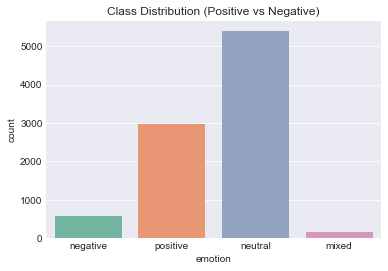

neutral     5388
positive    2978
negative     570
mixed        156
Name: emotion, dtype: int64


In [26]:
# Set plot style
plt.style.use('seaborn-darkgrid') 

# Count distribution
sns.countplot(x='emotion', data= text_cleaned, palette='Set2')
plt.title("Class Distribution (Positive vs Negative)")
plt.show()

# Print raw counts
print(text_cleaned['emotion'].value_counts())

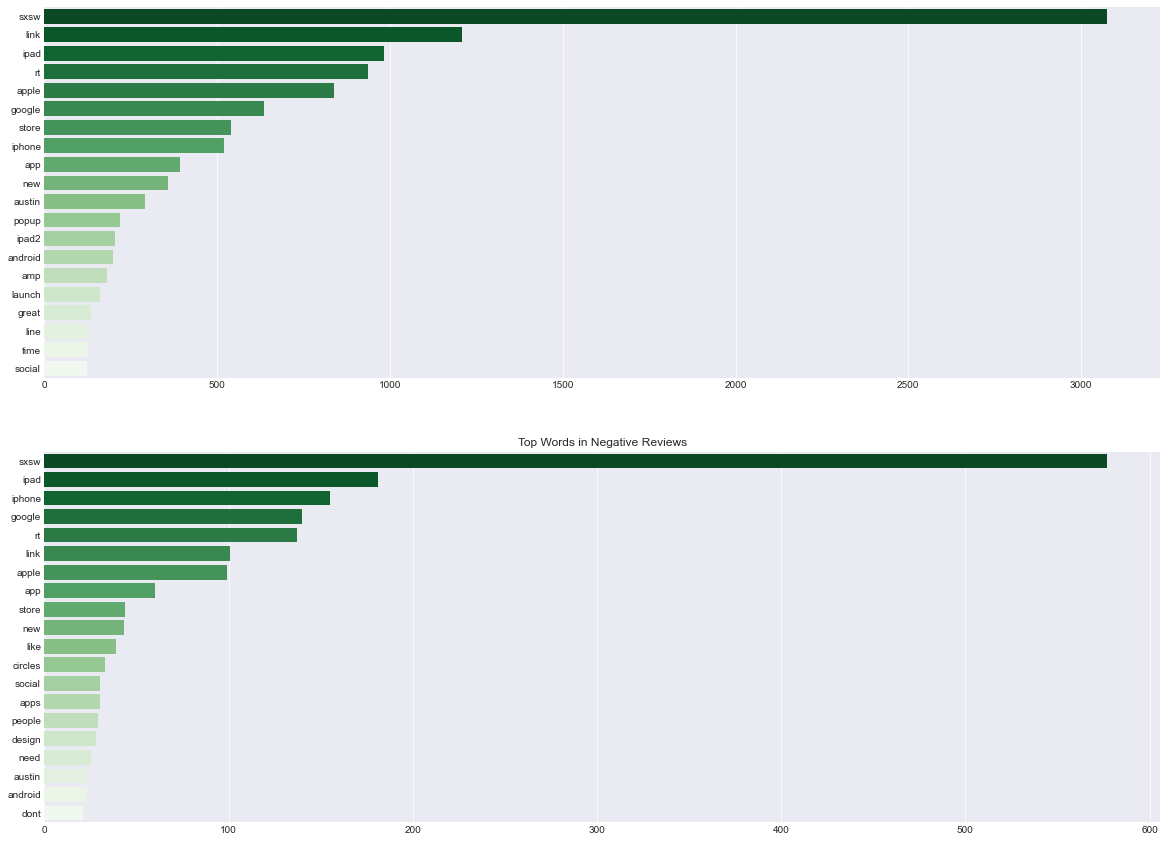

In [27]:
def get_top_words(texts, n=20):
    texts = [t for t in texts if isinstance(t, str) and t.strip() != ""]  # filter empty
    if len(texts) == 0:
        return []  # nothing to process

    vec = CountVectorizer(stop_words='english').fit(texts)
    bag_of_words = vec.transform(texts)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    return sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]

top_pos = get_top_words(text_cleaned[text_cleaned['emotion']=="positive"]['cleaned_tweets'])
top_neg = get_top_words(text_cleaned[text_cleaned['emotion']=="negative"]['cleaned_tweets'])

# Plotting example for positive
fig, (ax1, ax2) = plt.subplots(figsize= (20, 15), nrows= 2)

words, counts = zip(*top_pos)
sns.barplot(x=list(counts), y=list(words), palette="Greens_r", ax= ax1)
plt.title("Top Words in Positive Reviews")

words, counts = zip(*top_neg)
sns.barplot(x=list(counts), y=list(words), palette="Greens_r", ax= ax2)
plt.title("Top Words in Negative Reviews")
plt.show()


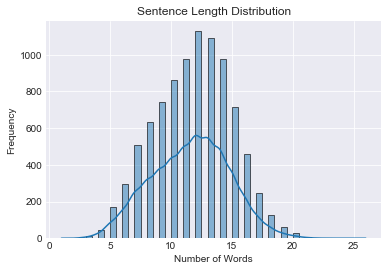

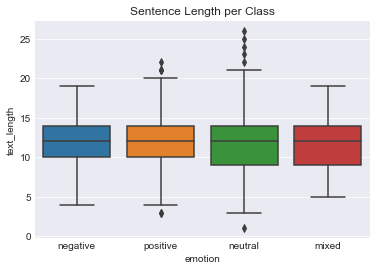

In [28]:
text_cleaned['text_length'] = text_cleaned['cleaned_tweets'].apply(lambda x: len(x.split()))

sns.histplot(text_cleaned['text_length'], bins=50, kde=True)
plt.title("Sentence Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

# Compare by class
sns.boxplot(x='emotion', y='text_length', data=text_cleaned)
plt.title("Sentence Length per Class")
plt.show()


In [29]:
# Most common words (including hashtags, mentions, etc.)... BEFORE preprocessing
all_words = ' '.join(text_cleaned['tweet']).split()
common_words = Counter(all_words).most_common(20)
print("Top 20 Most Frequent Words (Raw Tweets):")
print(common_words)

Top 20 Most Frequent Words (Raw Tweets):
[('#sxsw', 7830), ('@mention', 6703), ('the', 4357), ('{link}', 4255), ('to', 3561), ('at', 3054), ('rt', 2897), ('for', 2537), ('a', 2253), ('in', 1875), ('ipad', 1871), ('google', 1861), ('of', 1709), ('is', 1682), ('apple', 1634), ('and', 1588), ('on', 1303), ('store', 1225), ('new', 1082), ('i', 1050)]


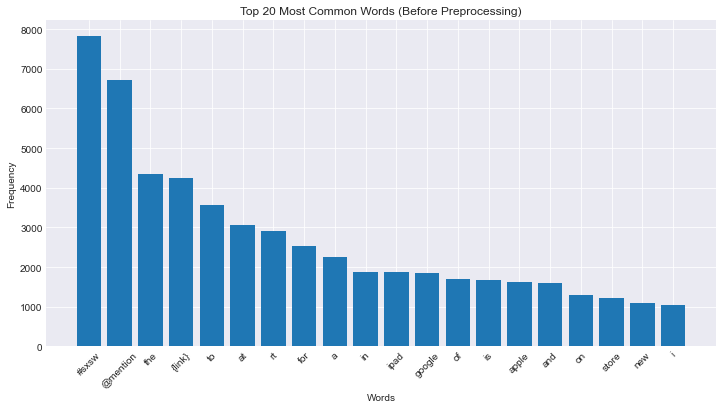

In [30]:
# Separate words and counts for plotting
Common_words = [word for word, count in common_words]
counts = [count for word, count in common_words]

# Plot
plt.figure(figsize=(12,6))
plt.bar(Common_words, counts)
plt.xticks(rotation=45)
plt.title("Top 20 Most Common Words (Before Preprocessing)")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

In [31]:
# Most common words AFTER preprocessing
words = ' '.join(text_cleaned['cleaned_tweets']).split()
word_counts = Counter(words).most_common(20)

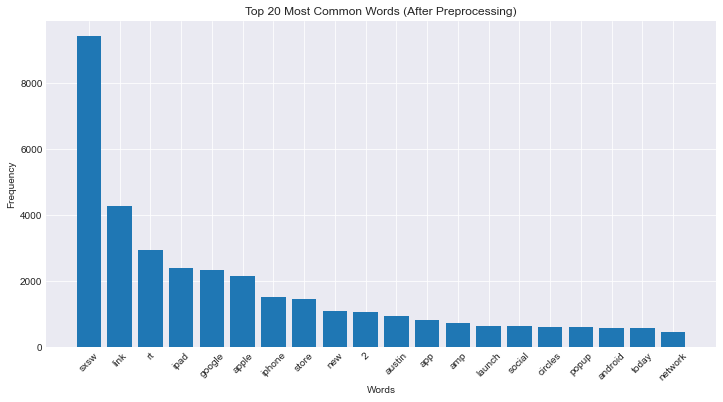

In [32]:
# Separate words and counts for plotting
common_words = [word for word, count in word_counts]
counts = [count for word, count in word_counts]

# Plot
plt.figure(figsize=(12,6))
plt.bar(common_words, counts)
plt.xticks(rotation=45)
plt.title("Top 20 Most Common Words (After Preprocessing)")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()